In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
from dds_loopback import DDSOverlay

In [2]:
#ol = DDSOverlay(bitfile_name='hw/top_dac_feedthrough_afe_w_spi.bit',dbg=True,plot=False,n_buffers=1,download=True)
#ol = DDSOverlay(bitfile_name='hw/top_dac_feedthrough_afe_w_spi_autotrig.bit',dbg=True,plot=False,n_buffers=1,download=True)
ol = DDSOverlay(bitfile_name='hw/top_dac_feedthrough_afe_w_spi_trig_select.bit',dbg=True,plot=False,n_buffers=1,download=True)

loading bitfile hw/top.bit


setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 81920 (2.000e+07Hz)
setting pinc to 192512 (4.700e+07Hz)
setting pinc to 81920 (2.000e+07Hz)
setting pinc to 6963201 (1.700e+09Hz)
setting pinc to 81920 (2.000e+07Hz)
setting pinc to 192512 (4.700e+07Hz)
setting pinc to 81920 (2.000e+07Hz)
setting pinc to 6963201 (1.700e+09Hz)


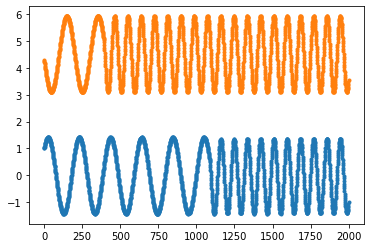

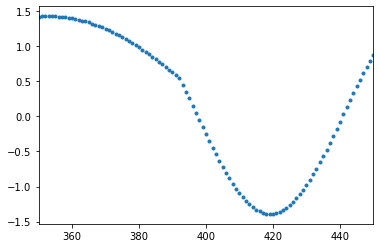

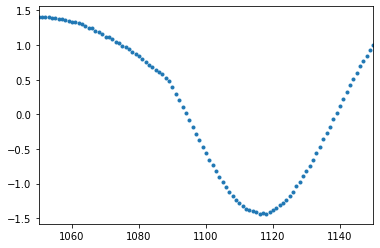

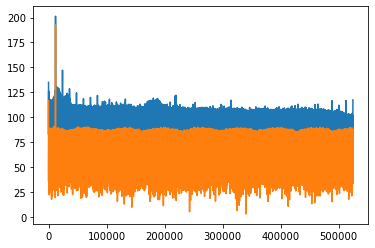

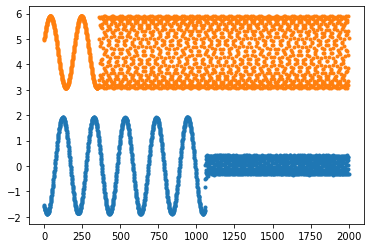

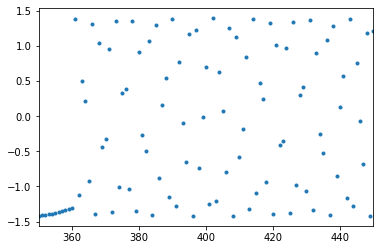

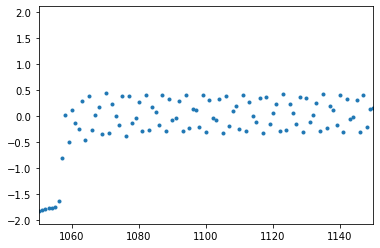

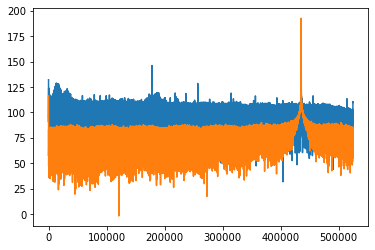

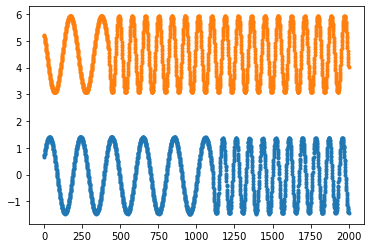

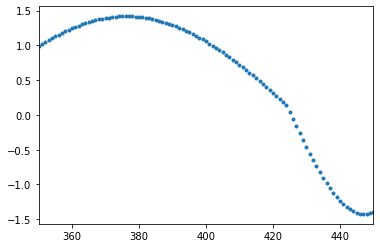

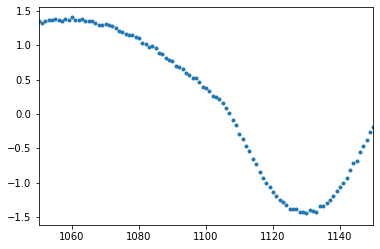

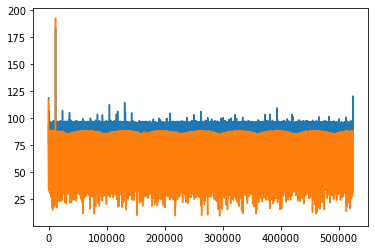

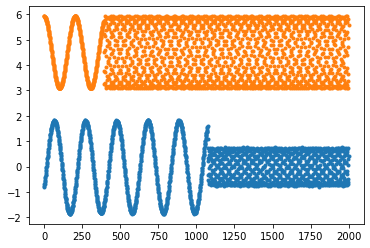

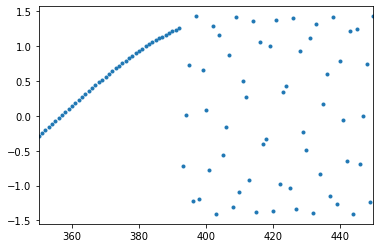

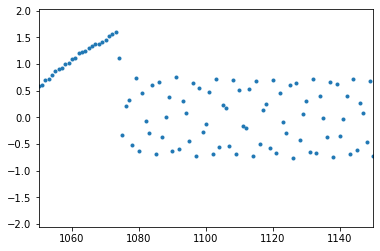

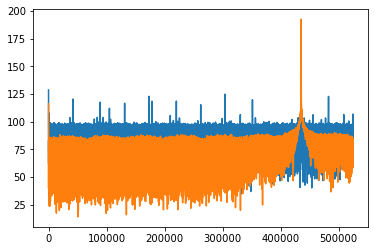

In [29]:
ol.plot = False
ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
freqs = np.array([47e6, 1700e6 + ol.f_samp/(2**ol.phase_bits)])
for source in ['afe', 'balun']:
    ol.set_adc_source(source)
    for i,freq in enumerate(freqs):
        # set to manual trigger so we can update the frequency without having to do DMA
        ol.set_sample_buffer_trigger_source('manual')
        ol.set_freq_hz(20e6)
        # set to auto trigger so that we capture the frequency change
        ol.set_sample_buffer_trigger_source('dds_auto')
        ol.set_freq_hz(freq)
        ol.dma(0)
        raw = ol.dma_buffers[0][1000:3000,:]*[-1, 1]
        raw = (raw - np.mean(raw, axis=0))/np.std(raw, axis=0)
        plt.figure()
        plt.plot(raw + [0, 4.5], '.')
        plt.figure()
        plt.plot(raw[:,1], '.')
        plt.xlim([350, 450])
        plt.figure()
        plt.plot(raw[:,0], '.')
        plt.xlim([1050, 1150])
        # set to manual trigger so that we can capture a full buffer of pure tone
        ol.set_sample_buffer_trigger_source('manual')
        ol.manual_trigger()
        ol.dma(0)
        plt.figure()
        plt.plot(20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0], axis=0))))
ol.set_adc_source('afe')

setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 262144 (6.400e+07Hz)
setting pinc to 6553600 (1.600e+09Hz)
t_intersect = [5.15621847e-07 3.43680497e-07]
coarse_delay_n = 704.2717706746648


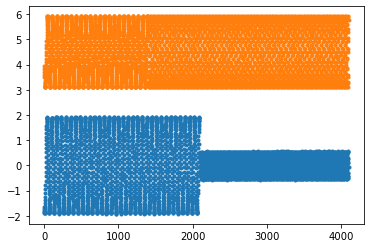

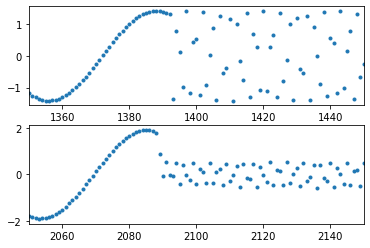

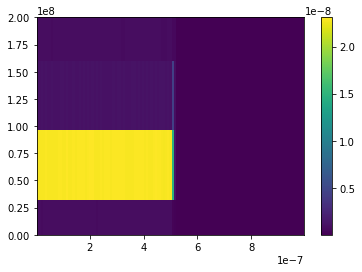

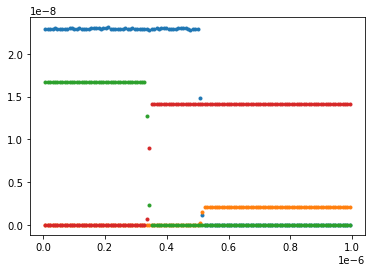

In [143]:
# get coarse phase delay with spectrogram
ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
ol.set_adc_source('afe')
ol.set_sample_buffer_trigger_source('manual')
tones = np.array([64e6, 1600e6])
ol.set_freq_hz(tones[0])
ol.set_sample_buffer_trigger_source('dds_auto')
ol.set_freq_hz(tones[1])
ol.dma(0)
raw = ol.dma_buffers[0][:4096,:]*[-1, 1]
raw = (raw - np.mean(raw, axis=0))/np.std(raw, axis=0)
plt.figure()
plt.plot(raw + [0, 4.5], '.')
fig, ax = plt.subplots(2,1)
ax[0].plot(raw[:,1], '.')
ax[0].set_xlim([1350, 1450])
ax[1].plot(raw[:,0], '.')
ax[1].set_xlim([2050, 2150])
N_fft = 64
N_overlap = 32
f, t, Sxx = scipy.signal.spectrogram(raw, ol.f_samp, axis=0, nfft=N_fft, nperseg=N_fft, noverlap=N_overlap)
plt.figure()
plt.pcolormesh(t, f, Sxx[:,0,:], shading='nearest')
plt.colorbar()
plt.ylim([0,200e6])
bin_idx = np.zeros(2, dtype=np.uint16)
for i in range(2):
    bin_idx[i] = (np.abs(f - tones[i])).argmin()
plt.figure()
plt.plot(t, np.transpose(Sxx[bin_idx,0,:]), '.')
plt.plot(t, np.transpose(Sxx[bin_idx,1,:]), '.')
n_intersect = np.zeros(2)
for i in range(2):
    S_lo_last = Sxx[bin_idx[0],i,0]
    S_hi_last = Sxx[bin_idx[1],i,0]
    for t_idx in range(1,len(t)):
        S_lo = Sxx[bin_idx[0],i,t_idx]
        S_hi = Sxx[bin_idx[1],i,t_idx]
        if S_hi > S_lo:
            n_intersect[i] = t[t_idx]*ol.f_samp + (S_hi - S_lo)/(S_lo - S_lo_last + S_hi_last - S_hi)
            S_lo_last = S_lo
            S_hi_last = S_hi
            break
print(f't_intersect = {n_intersect/ol.f_samp}')
coarse_delay_n = n_intersect[0] - n_intersect[1]
print(f'coarse_delay_n = {coarse_delay_n}')

(-1000.0, 2000.0)

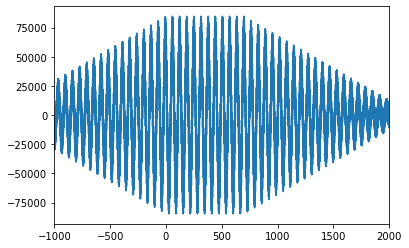

In [144]:
# get fine delay
OSR = 32
upsampled = scipy.signal.resample_poly(raw, OSR, 1, axis=0)
xc = scipy.signal.correlate(upsampled[:,0], upsampled[:,1])
lags = scipy.signal.correlation_lags(len(upsampled[:,0]), len(upsampled[:,1]))
plt.figure()
plt.plot(lags/OSR,xc)
plt.xlim([-1000, 2000])

In [148]:
lag_min = np.where(lags==int(coarse_delay_n-ol.f_samp/(4*tones[0]))*OSR)[0][0]
lag_max = np.where(lags==int(coarse_delay_n+ol.f_samp/(4*tones[0]))*OSR)[0][0]
lags[np.argmax(xc[lag_min:lag_max])+lag_min]

22298

(3.173828125e-07, 3.662109375e-07)

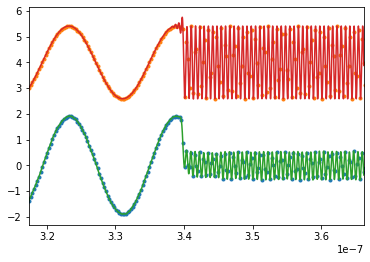

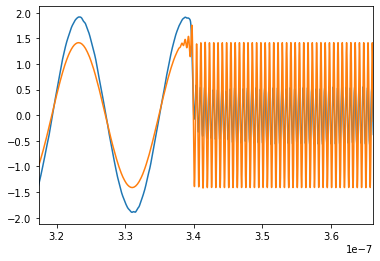

In [147]:
#delta_n = 691
delta_n_OSR = 22306#int(703.82*64)#703265
OSR = 32
tvec_0 = np.linspace(0,(raw.shape[0]-delta_n_OSR/OSR)/ol.f_samp,raw.shape[0]-int(delta_n_OSR/OSR),endpoint=False)
tvec_1 = np.linspace(0,raw.shape[0]/ol.f_samp,raw.shape[0],endpoint=False)
tvec_osr_0 = np.linspace(0,(raw.shape[0]-delta_n_OSR/OSR)/ol.f_samp,raw.shape[0]*OSR-delta_n_OSR,endpoint=False)
tvec_osr_1 = np.linspace(0,raw.shape[0]/ol.f_samp,raw.shape[0]*OSR,endpoint=False)
plt.figure()
plt.plot(tvec_0, raw[int(delta_n_OSR/OSR):,0], '.')
plt.plot(tvec_1, raw[:,1] + 4, '.')
plt.plot(tvec_osr_0, scipy.signal.resample_poly(raw[:,0], OSR, 1)[delta_n_OSR:], '-')
plt.plot(tvec_osr_1, scipy.signal.resample_poly(raw[:,1], OSR, 1) + 4, '-')
#plt.xlim([1400/ol.f_samp, 1600/ol.f_samp])
plt.xlim([1300/ol.f_samp, 1500/ol.f_samp])
plt.figure()
plt.plot(tvec_osr_0, scipy.signal.resample_poly(raw[:,0], OSR, 1)[delta_n_OSR:], '-')
plt.plot(tvec_osr_1, scipy.signal.resample_poly(raw[:,1], OSR, 1), '-')
#plt.xlim([1400/ol.f_samp, 1440/ol.f_samp])
plt.xlim([1300/ol.f_samp, 1500/ol.f_samp])

In [96]:
tvec_0

(5000, 2)

[ 54.1775376  100.99616793]


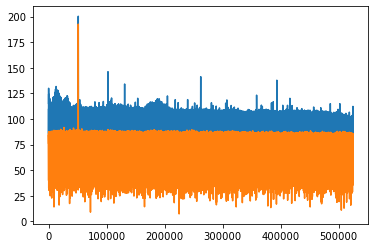

In [34]:
def sfdr_dBc(buffer, buffer_len=65536):
    fft = abs(np.fft.rfft(buffer, axis=0))[1:-1,:]
    fft.sort(axis=0)
    return 20*np.log10(fft[-1,:]/fft[-2,:])
print(sfdr_dBc(ol.dma_buffers[0]))

fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0], axis=0)))[1:-1,:]
plt.plot(fft)

setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 81920 (2.000e+07Hz)
transferred 4.0MiB in 106us (19.852GS/s)
setting pinc to 81928 (2.000e+07Hz)
transferred 4.0MiB in 100us (20.952GS/s)
setting pinc to 81936 (2.000e+07Hz)
transferred 4.0MiB in 100us (21.008GS/s)
setting pinc to 81944 (2.001e+07Hz)
transferred 4.0MiB in 99us (21.102GS/s)
setting pinc to 81952 (2.001e+07Hz)
transferred 4.0MiB in 98us (21.499GS/s)
setting pinc to 81960 (2.001e+07Hz)
transferred 4.0MiB in 99us (21.102GS/s)
setting pinc to 81969 (2.001e+07Hz)
transferred 4.0MiB in 100us (20.953GS/s)
setting pinc to 81977 (2.001e+07Hz)
transferred 4.0MiB in 100us (20.888GS/s)
setting pinc to 81985 (2.002e+07Hz)
transferred 4.0MiB in 98us (21.324GS/s)
setting pinc to 81993 (2.002e+07Hz)
transferred 4.0MiB in 101us (20.758GS/s)
setting pinc to 82001 (2.002e+07Hz)
transferred 4.0MiB in 99us (21.24GS/s)
setting pinc to 82010 (2.002e+07Hz)
transferred 4.0MiB in 98us (21.302GS/s)
setting p

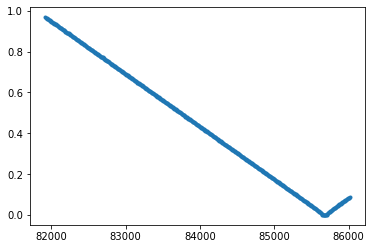

In [138]:
# calculate phase vs frequency
ol.plot = False

ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
freqs = np.linspace(20e6, 21e6, 501)
phase = np.zeros(freqs.shape)
for i,freq in enumerate(freqs):
    ol.set_freq_hz(freq)
    ol.capture_data(ol.dma_buffers[0])
    N_samp = 16384
    raw = ol.dma_buffers[0][:N_samp,:]
    raw = (raw - np.mean(raw, axis=0))/np.std(raw, axis=0)
    c = np.cov(np.transpose(raw))
    phase[i] = np.arccos(np.clip(c[0,1],-1,1))
# calculate phase_offset_200MHz and phase_inc_per_hz
phase_incs = ((freqs/ol.f_samp)*(2**ol.phase_bits)).astype(np.uint32)
A = np.vstack([phase_incs, np.ones(len(phase_incs))]).T
phase_inc_per_pinc_20MHz, phase_offset_pinc_20MHz = np.linalg.lstsq(A, phase, rcond=None)[0]
phase_offset_pinc_20MHz += phase_inc_per_pinc_20MHz*int((20e6/ol.f_samp)*(2**ol.phase_bits))
print(phase_inc_per_pinc_20MHz*2**24, phase_offset_pinc_20MHz)
plt.plot(phase_incs, phase, '.')

In [206]:
print(phase_inc_per_pinc_20MHz*2**24, phase_offset_pinc_20MHz)

-4157.475619017378 0.9547335876903951


setting pinc to 831488 (2.030e+08Hz)
setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
transferred 4.0MiB in 113us (18.622GS/s)


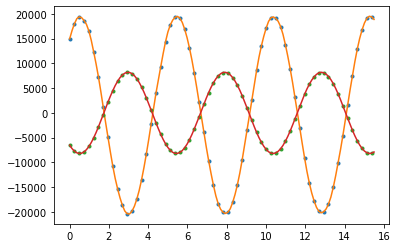

In [47]:
ol.plot = True
ol.set_freq_hz(203e6)
ol.set_vga_atten_dB(18)
ol.set_dac_atten_dB(12)
ol.capture_data(ol.dma_buffers[0], N_samp=64, OSR=2)

setting pinc to 819200 (2.000e+08Hz)
setting vga attenuation to 0dB
b'read attenuation back: 0dB\r\n'
b'Invalid character; please input attenuation in dB (as a 2-digit decimal) and press ENTER\r\n'
b'setting attenuation to 12dB\r\n'
b'read attenuation back: 0dB\r\n'
b'0\r\n'
b'setting attenuation to 0dB\r\n'
setting cos_scale to 0 (0dB attenuation)
transferred 4.0MiB in 118us (17.718GS/s)


NameError: name 'sfdr_dBc' is not defined

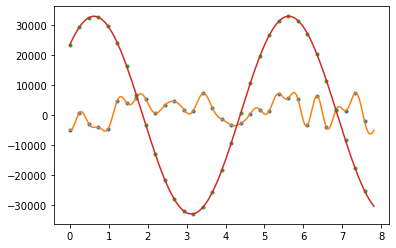

In [13]:
ol.set_freq_hz(200e6)
sfdr = np.zeros((33,11))
vga_atten_settings = np.linspace(0,32,33)
dac_atten_settings = np.linspace(0,60,11)
for v,vga_atten in enumerate(vga_atten_settings):
    ol.set_vga_atten_dB(vga_atten)
    for d,dac_atten in enumerate(dac_atten_settings):
        ol.set_dac_atten_dB(dac_atten)
        ol.capture_data(ol.dma_buffers[0], N_samp=32, OSR=1024)
        sfdr[v,d] = sfdr_dBc(ol.dma_buffers[0])
        print(f'for vga_atten = {vga_atten}, dac_atten = {dac_atten}, got SFDR = {sfdr[v,d]}')

In [62]:
scipy.io.savemat('data/afe_loopback_dac_sfdr_200MHz.mat', {'vga_atten': vga_atten_settings, 'dac_atten': dac_atten_settings, 'sfdr': sfdr, 'freq': 1.4e9})

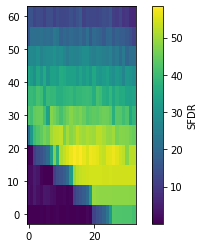

In [64]:
#plt.imshow(sfdr, interpolation=None, origin='lower', extent=[-3, 63, 0, 32])
v,d = np.meshgrid(vga_atten_settings, dac_atten_settings)
plt.pcolor(v, d, np.transpose(sfdr))
cb=plt.colorbar()
cb.set_label('SFDR')
plt.gca().set_aspect('equal')

In [9]:
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))

/tmp/ipykernel_14742/727962273.py:1: RuntimeWarning: divide by zero encountered in log10
  fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))


[-30.32266976967722, -84.45834857261463, -92.64246328227352, -93.48622157603435, -93.65850278301221]
54.135678802937406


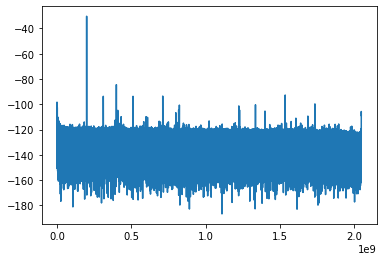

In [4]:
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0])))-20*np.log10(ol.dma_frame_size*(2**16))
fvec = np.linspace(0,ol.f_samp/2,ol.dma_frame_size//2+1,endpoint=True)
plt.plot(fvec[1:-1],fft[1:-1])
#plt.xlim([2.048e9-2e6, 2.048e9+2e6])
peaks = sorted(fft[1:-1], reverse=True)[:5]
print(peaks)
print(peaks[0] - peaks[1])

In [3]:
vga_setting = 0
for scale in [0, 6, 12, 30, 60]:
    ol.do_freq_sweep(f"data/afe_loopback_dac_{scale}dB_vga_{vga_setting}dB.mat", scale, np.logspace(4, 9.25, 200))

setting cos_scale to 0 (0dB attenuation)
setting pinc to 40 (1.000e+04Hz)
transferred 4.0MiB in 110us (19.086GS/s)
setting pinc to 43 (1.063e+04Hz)
transferred 4.0MiB in 90us (23.265GS/s)
setting pinc to 46 (1.129e+04Hz)
transferred 4.0MiB in 82us (25.591GS/s)
setting pinc to 49 (1.200e+04Hz)
transferred 4.0MiB in 81us (25.749GS/s)
setting pinc to 52 (1.275e+04Hz)
transferred 4.0MiB in 81us (25.818GS/s)
setting pinc to 55 (1.355e+04Hz)
transferred 4.0MiB in 82us (25.596GS/s)
setting pinc to 58 (1.440e+04Hz)
transferred 4.0MiB in 81us (25.833GS/s)
setting pinc to 62 (1.530e+04Hz)
transferred 4.0MiB in 82us (25.73GS/s)
setting pinc to 66 (1.626e+04Hz)
transferred 4.0MiB in 81us (25.884GS/s)
setting pinc to 70 (1.728e+04Hz)
transferred 4.0MiB in 82us (25.61GS/s)
setting pinc to 75 (1.836e+04Hz)
transferred 4.0MiB in 84us (24.978GS/s)
setting pinc to 79 (1.951e+04Hz)
transferred 4.0MiB in 82us (25.492GS/s)
setting pinc to 84 (2.073e+04Hz)
transferred 4.0MiB in 82us (25.612GS/s)
setting pin